#### Lab 06: Temporal analysis

##### Section: 1 - 2pm

##### Group #: 1

##### Student: Steven Yoo
##### UT EID: jy23294

##### Student: Sam Song
##### UT EID: sks3858

##### Student: CY Yun
##### UT EID: cy7233

We encounter time series data in pretty much every domain, from finance to weather, from public health to renewable energies. Visualizations of temporal data may represent recorded observations from the past and/or predicted developments for the future, which is why visual representations of temporal data are so important and interesting. Especially, in the context of the ongoing climate and covid crises we encounter many time series visualizations. 

This tutorial is structured into three basic phases: 1. Prepare, 2. Process, and 3. Present.


#### 1. Prepare 

Before we are able to do anything, we need to include the libraries that we are working with (as always):

In [1]:
import pandas as pd
import altair as alt
import scipy.signal # for the LOESS fitting

##### Parse dates and times

In its most basic form, time series data contain a quantitative measure that changes over time. To reference a time point we use [Timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html) of Pandas as the data type for temporal entities.

With **`to_datetime()`** you can create a Timestamp with a string containing a date and/or time. Pandas can infer the date and time from various date/time strings. Let's start with the present:


In [2]:
pd.to_datetime("now")

/var/folders/cm/tp384c9x4q78rhtw47g1d4800000gn/T/ipykernel_2333/2343923985.py:1: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  pd.to_datetime("now")


Timestamp('2023-10-14 03:16:49.084995')

We can pass a range of date formats and Pandas will guess which numbers refer to years, months, days, hours, etc.:

In [3]:
pd.to_datetime('2023-10-13 3pm')

Timestamp('2023-10-13 15:00:00')

When expressing dates and times in written language, there is an ambiguity between the order of different entities. The most frequent ambiguity concerns the order of days and months, as they are typyically both expressed in double-digit numbers, unlike years that tend to be expressed with four digits. However, date conventions vary across the world.  For example, the following date might be interpreted differently depending on the country; it may refer to Saint Nicholas Day in 1929 or Anne Frank's birthday:

In [4]:
pd.to_datetime('12.6.1929')

Timestamp('1929-12-06 00:00:00')

To clarify towards Pandas that the first number refers to the day, you can add the parameter **`dayfirst`**:

In [5]:
pd.to_datetime('12.6.1929', dayfirst=True)

Timestamp('1929-06-12 00:00:00')

The method `to_datetime()` can also handle an array of date strings; it will return a `DatetimeIndex`, which is crucial for temporal indexing with Pandas.

In [6]:
sessions=["2.4.2020", "9.4.2020", "16.4.2020", "23.4.2020", "7.5.2020", "14.5.2020", "28.5.2020", "4.6.2020", "11.6.2020", "25.6.2020", "2.7.2020", "9.7.2020"]
pd.to_datetime(sessions, dayfirst=True)

DatetimeIndex(['2020-04-02', '2020-04-09', '2020-04-16', '2020-04-23',
               '2020-05-07', '2020-05-14', '2020-05-28', '2020-06-04',
               '2020-06-11', '2020-06-25', '2020-07-02', '2020-07-09'],
              dtype='datetime64[ns]', freq=None)

If you want to make extra sure that the date/time string is parsed correctly and quickly, you can pass a fixed **`format`** for the date/time strings to be parsed:

In [7]:
pd.to_datetime('2020-05-07', format="%Y-%m-%d")

Timestamp('2020-05-07 00:00:00')

*see [list of format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)!*

##### Load time series data

In this tutorial we will be analyzing energy use in Germany from 2015 until 2018. 

First we will load the freely accessible data from the [OPSD project](https://open-power-system-data.org). `read_csv()` has a convenient feature, which lets you specify the column containing date/time information.

In [8]:
# read and create data frame and parse the dates

df = pd.read_csv('german_energy_data.csv', parse_dates=['datetime']) 

###### Do Sanity Checks

In [9]:
df.shape

(35064, 4)

In [10]:
df.head()

datetime   load  solar  wind
0 2014-12-31 23:00:00+00:00  41987      0  8644
1 2015-01-01 00:00:00+00:00  40665      0  8814
2 2015-01-01 01:00:00+00:00  39510      0  9054
3 2015-01-01 02:00:00+00:00  38537      0  9070
4 2015-01-01 03:00:00+00:00  38153      0  9164

In [11]:
df.tail()

datetime   load  solar   wind
35059 2018-12-31 18:00:00+00:00  52829      0  16438
35060 2018-12-31 19:00:00+00:00  49667      0  17587
35061 2018-12-31 20:00:00+00:00  47369      0  18872
35062 2018-12-31 21:00:00+00:00  46890      0  20270
35063 2018-12-31 22:00:00+00:00  45079      0  21405

In [12]:
df.tail()

datetime   load  solar   wind
35059 2018-12-31 18:00:00+00:00  52829      0  16438
35060 2018-12-31 19:00:00+00:00  49667      0  17587
35061 2018-12-31 20:00:00+00:00  47369      0  18872
35062 2018-12-31 21:00:00+00:00  46890      0  20270
35063 2018-12-31 22:00:00+00:00  45079      0  21405

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  35064 non-null  datetime64[ns, UTC]
 1   load      35064 non-null  int64              
 2   solar     35064 non-null  int64              
 3   wind      35064 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 1.1 MB


In [14]:
df.describe()

load         solar          wind
count  35064.000000  35064.000000  35064.000000
mean   55923.248546   4180.542665  10429.418863
std    10081.865874   6412.483093   8190.691684
min    31455.000000      0.000000    135.000000
25%    47505.000000      0.000000   4096.000000
50%    55628.000000    122.000000   8084.500000
75%    64862.250000   6619.250000  14700.000000
max    79063.000000  28955.000000  44629.000000


The time parsing resulted in one hour to be included from 2014. This is because this dataset covers the years 2015-2018 according to German time, while the generic UTC time is one hour 'behind'. To avoid having this stray hour in the old year, we revert the timestamps back to Germany's timezone:

In [15]:
df["datetime"] = df["datetime"].dt.tz_convert("Europe/Berlin")
df.head()

datetime   load  solar  wind
0 2015-01-01 00:00:00+01:00  41987      0  8644
1 2015-01-01 01:00:00+01:00  40665      0  8814
2 2015-01-01 02:00:00+01:00  39510      0  9054
3 2015-01-01 03:00:00+01:00  38537      0  9070
4 2015-01-01 04:00:00+01:00  38153      0  9164

Did you notice that solar energy appears to be zero at the beginning and at the end of the DataFrame? Take a look at the time and you'll know why.

In order to get a random data `sample()` there is a method of the same name, which gives us a random set of rows:

In [16]:
df.sample(10)

datetime   load  solar   wind
34140 2018-11-23 12:00:00+01:00  70082   6598   2182
6293  2015-09-20 06:00:00+02:00  37335      2   6575
5353  2015-08-12 02:00:00+02:00  42007      0   3572
4914  2015-07-24 19:00:00+02:00  58217   2786   5223
13042 2016-06-27 11:00:00+02:00  67394  18508   9529
10125 2016-02-26 21:00:00+01:00  57075      0   2308
15156 2016-09-23 13:00:00+02:00  63019  18163   3865
22187 2017-07-13 12:00:00+02:00  68155  21436   8388
24665 2017-10-24 18:00:00+02:00  70150      1  16199
24736 2017-10-27 17:00:00+02:00  64526    796  21060

Now, let's take a look at the data types and values contained in our DataFrame:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype                        
---  ------    --------------  -----                        
 0   datetime  35064 non-null  datetime64[ns, Europe/Berlin]
 1   load      35064 non-null  int64                        
 2   solar     35064 non-null  int64                        
 3   wind      35064 non-null  int64                        
dtypes: datetime64[ns, Europe/Berlin](1), int64(3)
memory usage: 1.1 MB


The values in the columns `load`, `solar` and `wind` are provided in the unit megawatt (MW) as integers.

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame:

In [18]:
df = df.set_index("datetime")

When we run `df.info()` again, you will see that the DataFrame now has a `DatetimeIndex`:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   load    35064 non-null  int64
 1   solar   35064 non-null  int64
 2   wind    35064 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


The `DatetimeIndex` provides a few handy methods to extract temporal units such as months, days, week of the year, etc.: 

In [20]:
df.index.year.unique()

Int64Index([2015, 2016, 2017, 2018], dtype='int64', name='datetime')

*Look here for syntax to extract any other [temporal attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html)*

#### 2. Process

The dataset contains over 35000 rows each of which contains data on overall energy load and renewable energy production. To make sense of all this data, we need to process the time series data into various chunks and sizes!


### Query time points and spans

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

One useful function of a temporal index, is its querying function. We can quickly extract the rows for a given time point or period.

Let's get the data for the day with the most daylight of 2017, i.e., the summer solstice or midsummer:

In [21]:
df.loc["2017-06-21"]

load  solar  wind
datetime                                     
2017-06-21 00:00:00+02:00  48260      0  7394
2017-06-21 01:00:00+02:00  46107      0  6460
2017-06-21 02:00:00+02:00  44959      0  5894
2017-06-21 03:00:00+02:00  45136      0  5472
2017-06-21 04:00:00+02:00  45486      3  5008
2017-06-21 05:00:00+02:00  47746    303  4602
2017-06-21 06:00:00+02:00  55753   2095  3688
2017-06-21 07:00:00+02:00  62259   5926  2113
2017-06-21 08:00:00+02:00  65541  11142  1482
2017-06-21 09:00:00+02:00  66445  16371  1357
2017-06-21 10:00:00+02:00  67583  20532  1433
2017-06-21 11:00:00+02:00  69075  23605  1579
2017-06-21 12:00:00+02:00  68885  25016  1649
2017-06-21 13:00:00+02:00  68394  24559  1649
2017-06-21 14:00:00+02:00  67317  23135  1568
2017-06-21 15:00:00+02:00  66180  21010  1514
2017-06-21 16:00:00+02:00  64622  17896  1364
2017-06-21 17:00:00+02:00  63853  13387  1332
2017-06-21 18:00:00+02:00  62661   8149  1250
2017-06-21 19:00:00+02:00  61868   3776  1148
2017-06-21 20:00:00+02:00  59841   1309  1232
2017-06-21 21:00:00+02:00  57190    109  1189
2017-06-21 22:00:00+02:00  55267      0  1226
2017-06-21 23:00:00+02:00  51282      0  1416

Above query is an example of partial-string indexing: while our `DateTime` column actually contains time information as well, you can query it quickly (!) with just the date, or even a shorter query:

In [22]:
df.loc["2017-06"]

load  solar   wind
datetime                                      
2017-06-01 00:00:00+02:00  46372      0   7902
2017-06-01 01:00:00+02:00  44690      0   7233
2017-06-01 02:00:00+02:00  43592      0   6642
2017-06-01 03:00:00+02:00  43745      0   6174
2017-06-01 04:00:00+02:00  44374      3   6160
...                          ...    ...    ...
2017-06-30 19:00:00+02:00  59717   3010  12646
2017-06-30 20:00:00+02:00  56061    876  10976
2017-06-30 21:00:00+02:00  53473     40   9854
2017-06-30 22:00:00+02:00  51574      0   9544
2017-06-30 23:00:00+02:00  48271      0   9620

[720 rows x 3 columns]

You can also query a time period. Do you remember the storm Xavier that hit Germany in early October 2017? Let's retrieve the data around this time:

In [23]:
df.loc["2017-10-04":"2017-10-06"]

load  solar   wind
datetime                                      
2017-10-04 00:00:00+02:00  43116      0  19096
2017-10-04 01:00:00+02:00  41615      0  19163
2017-10-04 02:00:00+02:00  41348      0  19162
2017-10-04 03:00:00+02:00  41851      0  19020
2017-10-04 04:00:00+02:00  43778      0  19456
...                          ...    ...    ...
2017-10-06 19:00:00+02:00  65038      0  21984
2017-10-06 20:00:00+02:00  60991      0  21764
2017-10-06 21:00:00+02:00  57189      0  21500
2017-10-06 22:00:00+02:00  53925      0  20276
2017-10-06 23:00:00+02:00  49089      0  19739

[72 rows x 3 columns]

##### Aggregate values along time

The data we retrieved from OPSD, comes in the granularity of hours. To better understand the data it can be useful to reduce the data resolution and consider, for example, the total energy used/produced everyday or the daily averages over the course of entire years.

The DataFrame's `resample()` [doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) method provides a concise and quick way of aggregating temporally indexed data along time units. Here we create a DataFrame with summed up values for each year aggregated from the original dataset:

In [24]:
sums = df.resample("Y").sum()
sums

load     solar       wind
datetime                                                 
2015-12-31 00:00:00+01:00  477924124  34907138   77468981
2016-12-31 00:00:00+01:00  481084453  34562824   77001342
2017-12-31 00:00:00+01:00  493271535  35882643  102651209
2018-12-31 00:00:00+01:00  508612675  41233943  108575611

The resample operations can also be carried out one after another. For example, we might want to know how weekly energy use/production varies between the quarters:

In [25]:
# first we create the sums per week
weekly_sums = df.resample("W").sum()
# then we generate the weekly means for each quarter
quarterly_means = weekly_sums.resample("Q").mean()
# for readability we'll revert the values back to integers
quarterly_means.astype(int)

load    solar     wind
datetime                                             
2015-03-31 00:00:00+02:00   9236885   358245  1563098
2015-06-30 00:00:00+02:00   8666798  1013041  1195968
2015-09-30 00:00:00+02:00   8979745   978020  1152864
2015-12-31 00:00:00+01:00   9528732   326486  1952230
2016-03-31 00:00:00+02:00   9457773   314465  1923228
2016-06-30 00:00:00+02:00   8847897   995637  1234926
2016-09-30 00:00:00+02:00   8842918  1046984   990449
2016-12-31 00:00:00+01:00   9664017   296777  1691937
2017-03-31 00:00:00+02:00   9916792   376473  2178930
2017-06-30 00:00:00+02:00   9071470  1108284  1596890
2017-09-30 00:00:00+02:00   8969073   979390  1348998
2017-12-31 00:00:00+01:00   9779482   288079  2738409
2018-03-31 00:00:00+02:00  10310093   393263  2621168
2018-06-30 00:00:00+02:00   9406488  1191144  1722713
2018-09-30 00:00:00+02:00   9483386  1184625  1401228
2018-12-31 00:00:00+01:00   9901526   341216  2682958
2019-03-31 00:00:00+01:00   1119959     9329   230643

##### 3. Present

Enough data processing. It's time for visualization!

#### Time spans

One of the first time visualizations was [*A Chart of Biography*](https://en.wikipedia.org/wiki/A_Chart_of_Biography) (1765) by Joseph Priestley. Let's create a similar visualization of the US presidencies since World War II. First we load the CSV file with `pd.read_csv()`:

In [26]:
presidents = pd.read_csv('us_presidents.csv')

In [27]:
presidents.shape

(14, 4)

In [28]:
presidents.head()

name  start   end       party
0       Harry S. Truman   1945  1953  Democratic
1  Dwight D. Eisenhower   1953  1961  Republican
2       John F. Kennedy   1961  1963  Democratic
3     Lyndon B. Johnson   1963  1969  Democratic
4         Richard Nixon   1969  1974  Republican

In [29]:
presidents.tail()

name  start   end       party
9     Bill Clinton   1993  2001  Democratic
10  George W. Bush   2001  2009  Republican
11    Barack Obama   2009  2017  Democratic
12    Donald Trump   2017  2021  Republican
13       Joe Biden   2021  2025  Democratic

In [30]:
presidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    14 non-null     object
 1   start   14 non-null     int64 
 2   end     14 non-null     int64 
 3   party   14 non-null     object
dtypes: int64(2), object(2)
memory usage: 580.0+ bytes


The start and end times of the presidencies are given as four-digit integers, i.e., years. To convey towards Pandas and Altair that the start and end columns are actually dates, we need to parse them using the `to_datetime()` method:

In [31]:
presidents['start'] = pd.to_datetime(presidents['start'], format="%Y") 
presidents['end'] = pd.to_datetime(presidents['end'], format="%Y") 

The following chart consists of two parts: `bars` and `labels`. The former will be the main bar chart representing the time spans of the presidencies, and the latter will add the presidents' names. This way we can position the labels right next to the bars, much nicer!

In [32]:
# we add height as a parameter to make the time spans appear less clunky
bars = alt.Chart(presidents).mark_bar(height=5).encode(
    # this time we need two columns for x-position
    x='start', x2='end',
    # we sort by start dates and hide the axis, as names are added below
    y=alt.Y('name', sort='x', axis=None),
    color="party"
)

# the labels are added to the barchart using the mark_text command
labels = bars.mark_text(align='right', dx=-5).encode(text='name')

# both charts integrated into a layered chart through the magic of a plus sign
(bars + labels).properties(width=800, height=400)

alt.LayerChart(...)

##### Overall trends

Next, we are going to return to the energy time series data that we prepared above. Remember that the original dataset has an hourly resolution resulting in too many data points to visualize at once. Altair itself handles at most 5000 data rows.

To reduce the dataset into a manageable size, we  will create daily sums with the `resample()` method of the DateTimeIndex:

In [33]:
days = df.resample("D").sum()

To visualize the contents of the DataFrame with Altair, we turn the date/time information in the index into its own column `datetime` again and transform the DataFrame from [wide to long form](https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data) using the `melt()` method. We pass the name of the `datetime` column to the melt method so that it is treated as an index variable. To keep it short, these two steps `reset_index()` and `melt("datetime")` are done in one go right when we create the `Chart()`, which is what we are going to the in the rest of the tutorial.

Now let's start with a scatterplot visualization of the daily data:

In [34]:
# Break down the long form of the data so we can see that it works
days.reset_index().melt("datetime",var_name='Type')

datetime  Type    value
0    2015-01-01 00:00:00+01:00  load  1061334
1    2015-01-02 00:00:00+01:00  load  1267901
2    2015-01-03 00:00:00+01:00  load  1124883
3    2015-01-04 00:00:00+01:00  load  1072455
4    2015-01-05 00:00:00+01:00  load  1304357
...                        ...   ...      ...
4378 2018-12-27 00:00:00+01:00  wind   286302
4379 2018-12-28 00:00:00+01:00  wind   227879
4380 2018-12-29 00:00:00+01:00  wind   511284
4381 2018-12-30 00:00:00+01:00  wind   590481
4382 2018-12-31 00:00:00+01:00  wind   230643

[4383 rows x 3 columns]

In [35]:
alt.Chart(days.reset_index().melt("datetime")).mark_circle().encode(
    x='datetime',
    y='value',
    color='variable',
).properties(width=800, height=400)

alt.Chart(...)

With this our eyes can already see several patterns going on. Some are more dictinct than others. Interestingly, the load data (blue) seems to have two separate, but parallel curves‚Ä¶

‚úèÔ∏è *There is a lot of overplotting going on. Reduce the `size` and `opacity` of all dots, by passing these as parameters to `mark_circle`!*

Next, we are going to connect the dots and create a line chart form this data. So basically the same code as above, except we're now using `mark_line()` instead of `mark_circle`:

In [36]:
alt.Chart(days.reset_index().melt("datetime")).mark_line(strokeWidth=1).encode(
    x='datetime',
    y='value',
    color='variable',
).properties(width=800, height=400)

alt.Chart(...)

This chart already shows a lot: we can see weekly patterns‚Äîthe jittery up and down‚Äîin the load (blue) and the seasonal patterns in the form of broad waves in the load and solar curves (blue and yellow). Right around the turn of the year we see a drop of energy load.

While above line chart is truthful to the local fluctuations, it makes it hard to actually grasp the up and down over the course of months and years. Let's change the sampling from days to months to examine the overall patterns in the data.

In [37]:
months = df.resample("M").sum()

# to make the line a bit smoother, we include an interpolate parameter
alt.Chart(months.reset_index().melt("datetime")).mark_line(opacity=0.75, interpolate="basis").encode(
    x='datetime',
    y='value',
    color='variable',
).properties(width=800, height=400)

alt.Chart(...)

What do you think? The fine-grained jitter is now gone and we might have lost too much detail. In fact, first downsampling the data and then including an interpolation is maybe giving it too much of a treatment (like overusing Photoshop's blur function). For example, the load minima around the turns of the year are not visible as the overall energy load in the winter months appears larger. One the other hand, the solar curve has become an almost perfect sine wave, probably relating to the position of the sun across the year.

üí° *Play with different granularities in he `resample()` step. For example, use **W** for week or **Q** for quarter!*

One way to integrate the local and global patterns is to create a layered graph, as we have already done with the presidents' names above. This time we are combining a line chart of the days with a line chart of monthly averages.

Note how we ensure that both DataFrames fit the same data scale. As we're looking at energy values per day, we first generate the daily sums and on this basis the monthly means:

In [38]:
days = df.resample("D").sum()
months = days.resample("M").mean()

Next we create the line charts and combine the two again with the **+** operator:

In [39]:
chart1 = alt.Chart(days.reset_index().melt("datetime")).mark_line(strokeWidth=1, opacity=0.25).encode(
    x='datetime',
    y='value',
    color='variable',
).properties(width=800, height=400)

chart2 = alt.Chart(months.reset_index().melt("datetime")).mark_line(interpolate="basis", opacity=1).encode(
    x='datetime',
    y='value',
    color='variable',
)

chart1 + chart2

alt.LayerChart(...)

With this view we already get a good sense of the overall time patterns, while still seeing some of the particular variations.

üí° *You can add the `.interactive()` directive to one of these charts to make them zoomable!*

### Rolling windows

While the `resample()` method takes a broad brush and results in a reduced dataset and a chart with smooth curves, `rolling()` offers an alternative way of smoothing out local outliers without actually reducing the resolution of the dataset.

The first parameter determines the window size, by positioning the window at the `center` values are considered in both directions of the current date/time, and `win_type` determines how the values across the window are weighted; with the `triang` option the values further away contribute less:

In [40]:
rolling = days.rolling(60, center=True, win_type="triang").mean()

chart1 = alt.Chart(rolling.reset_index().melt("datetime")).mark_line(strokeWidth=1.5, opacity=1).encode(
    x='datetime', y='value', color='variable',
).properties(width=800, height=400)

# same as the two charts in previous code cell, except more transparent
chart2 = alt.Chart(days.reset_index().melt("datetime")).mark_line(strokeWidth=1, opacity=0.1).encode(
    x='datetime', y='value', color='variable',
)

chart3 = alt.Chart(months.reset_index().melt("datetime")).mark_line(interpolate="basis", opacity=.25).encode(
    x='datetime', y='value', color='variable',
)

chart1 + chart2 + chart3

alt.LayerChart(...)

Above you see the two lines for daily sums and monthly averages from the previous cell (slightly more transparent), on top of which you can see the time curve generated with a rolling window. It is quite apparent that this curve still features more pronounced dips around the end-of-year periods and elsewhere.


üí° *Play around with different window sizes and other parameters in the first line in above cell!*

### Detailed views

Some trends seem to pan out at much lower scales, which require higher levels of detail. For example, at the beginning of 2018 we see a peak in the wind energy production. In the winter of 2017/2018 Germany and most of Europe actually witnessed several storms. And so it also happened in the first days of 2018, when [Burglind (a.k.a. Eleanor)](https://en.wikipedia.org/wiki/Storm_Eleanor_(2018)) passed by. Let's take a closer look at the first week of January 2018. For this we extract a subset of the DataFrame using our tried and tested `loc[]`, which lets us select specific time spans:

In [41]:
burglind = df.loc["2018-01-01":"2018-01-07"]

alt.Chart(burglind.reset_index().melt("datetime")).mark_line().encode(
    x='datetime',
    y='value',
    color='variable'
).properties(width=800, height=400)

alt.Chart(...)

### High-level bars

In contrast to the detailed close-up, we might also want to look at much more general patterns. Let's say we are curious about the total production of renewable energy over the four years in the dataset. 

For this we `resample` the original data from hourly data resolution into summed up values per year:

In [42]:
years = df.resample("Y").sum()

Next we create a new column, which contains the summed up values of solar and wind production.

In [43]:
years["renewable"] = years["solar"]+years["wind"]

We `drop` the other value columns:

In [44]:
renewable = years.drop(columns=["load", "solar", "wind"])

Extract the years and create a specific column:

In [45]:
renewable["year"] = years.index.year
renewable

renewable  year
datetime                                  
2015-12-31 00:00:00+01:00  112376119  2015
2016-12-31 00:00:00+01:00  111564166  2016
2017-12-31 00:00:00+01:00  138533852  2017
2018-12-31 00:00:00+01:00  149809554  2018

And we remove the datetime index, and this time discard it (i.e., `drop=True`), as we have the `year` column already:

In [46]:
renewable = renewable.reset_index(drop=True)
renewable

renewable  year
0  112376119  2015
1  111564166  2016
2  138533852  2017
3  149809554  2018

Now we can create a simple barchart from this:

In [47]:
alt.Chart(renewable).mark_bar(width=30, fill="purple").encode(
    x='year:O',
    y='renewable:Q'
).properties(width=300, height=300)

alt.Chart(...)

##### Cyclical patterns

Previously, we did notice a few recurring patterns in the energy load. One pattern might be due to the weekly work-and-leasure patterns. 

So let's take a closer look at the average energy `load` over the course of a week:


In [48]:
# remove solar and wind columns
weekdays = df.drop(columns=["solar", "wind"])

# add a column for weekdays
weekdays["weekday"] = weekdays.index.weekday

This time we do not use `resample()` to change the data granularity, but `groupby()` to study recurring data patterns, because we are actually interested in the energy load for each *generic* weekday across the entire dataset:

In [49]:
weekdays = weekdays.groupby("weekday").mean()

alt.Chart(weekdays.reset_index()).mark_bar(width=20).encode(
    x='weekday:O',
    y='load:Q'
).properties(width=300, height=300)

alt.Chart(...)

It's quite apparent that energy load is lower during weekends.

##### Interactive selection

If you want it all: A high-level overview and detailed close-ups, you might need two coordinated views:

In [50]:
weeks = df.resample("W").sum()
days = df.resample("D").sum()

brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(weeks.reset_index().melt("datetime")).mark_area(interpolate="basis").encode(
    x = alt.X('datetime:T', axis=None),
    y = alt.Y('value:Q', axis=None),
    color='variable'
).properties(width=800, height=50).add_selection(brush)

lower = alt.Chart(days.reset_index().melt("datetime")).mark_line(strokeWidth=1).encode(
    x = alt.X('datetime:T', scale=alt.Scale(domain=brush)),
    y='value',
    color='variable',
).properties(width=800, height=300)

upper & lower

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection' is deprecated.
   Use 'selection_point()' or 'selection_interval()' instead; these functions also include more helpful docstrings.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.VConcatChart(...)

Note: The small stacked graph above the main chart is interactive, you can adjust the viewport of the line graph by dragging a time span with it.

#### Your turn

Apply your understanding of the above topics and answer the following 6 questions

In [51]:
# 1 - Look at the documentation to translate the string to datetime using the correct format for VE day
pd.to_datetime('8.5.1945 23:01', format="%d.%m.%Y %H:%M")

Timestamp('1945-05-08 23:01:00')

In [52]:
# 2 - append code to `df.index` below that shows what time zone the data is in
df.index.tz

<DstTzInfo 'Europe/Berlin' LMT+0:53:00 STD>

In [53]:
# 3 - Use date slicing/indexing to find the mean of the solar energy from 
# 21 June 2018 and the mean of the solar energy from 20 December 2018
df.loc['2018-06-21']['solar'].mean()

7543.791666666667

In [54]:
df.loc['2018-12-20']['solar'].mean()

767.4583333333334

In [56]:
# 4 - How did daily sum energy use/production change over the years? (calculate the daily sum, then the year average)
# and show the resulting dataframe

daily_sums = df.resample('D').sum()

yearly_average = daily_sums.resample("Y").mean()

yearly_average

load          solar           wind
datetime                                                             
2015-12-31 00:00:00+01:00  1.309381e+06   95635.994521  212243.783562
2016-12-31 00:00:00+01:00  1.314438e+06   94433.945355  210386.180328
2017-12-31 00:00:00+01:00  1.351429e+06   98308.610959  281236.189041
2018-12-31 00:00:00+01:00  1.393459e+06  112969.706849  297467.427397

In [57]:
# 5 - Create a horizontal bar chart showing total renewable energy over the years
df['renewable'] = df['solar'] + df['wind']
yearly_sum = df.resample("Y").sum()
yearly_sum['year'] = years.index.year

alt.Chart(yearly_sum).mark_bar(width=20).encode(
    x = ('renewable:Q'),
    y = ('year:O'),
).properties(width = 400, height = 300)

alt.Chart(...)

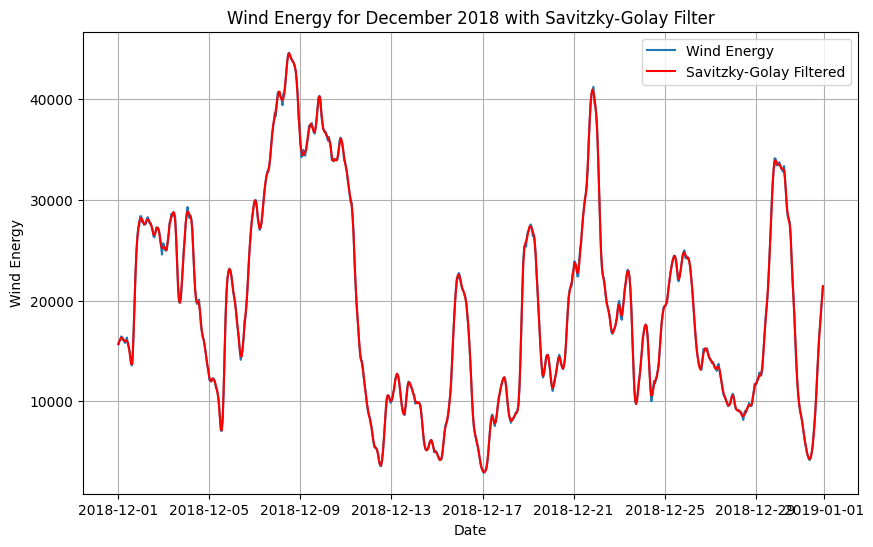

In [59]:
# 6 - Show the wind energy for the month of Dec 2018 along with the Savitzky‚ÄìGolay filter line overlayed on top. 
# as a line chart.  Set your window for one week of data. Play around with the polynomial order until you 
# get something you like. 

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

dec_2018_wind = df['2018-12-01':'2018-12-31']['wind']

filtered_dec_2018_wind = savgol_filter(dec_2018_wind, window_length = 7, polyorder = 3)

plt.figure(figsize=(10, 6))
plt.plot(dec_2018_wind.index, dec_2018_wind, label = 'Wind Energy')
plt.plot(dec_2018_wind.index, filtered_dec_2018_wind, label = 'Savitzky-Golay Filtered', color = 'red')
plt.xlabel('Date')
plt.ylabel('Wind Energy')
plt.title('Wind Energy for December 2018 with Savitzky-Golay Filter')
plt.legend()
plt.grid(True)

# Show the chart
plt.show()


## Sources

Tutorials & Examples
- [‚Äã‚Äã‚Äã‚ÄãTutorial: Time Series Analysis with Pandas by Jennifer Walker](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)
- [Altair Interval Selection Example](https://altair-viz.github.io/gallery/interval_selection.html)

Documentation: Pandas
- [Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- [Timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)
- [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html)
- [Time-aware rolling vs. resampling](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#time-aware-rolling-vs-resampling)

